In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [276]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import gzip 
import tqdm
import requests



def harmonic_sum(data, scale_factor=1, cap=None):
    """
    Returns an harmonic sum for the data passed
    Args:
        data (list): list of floats to compute the harmonic sum from
        scale_factor (float): a scaling factor to multiply to each datapoint. Defaults to 1
        cap (float): if not None, never return an harmonic sum higher than the cap value.
    Returns:
        harmonic_sum (float): the harmonic sum of the data passed
    """
    
    if isinstance(data, pd.Series):
        data = data.tolist()

    data.sort(reverse=True)
    harmonic_sum = sum(s / ((i+1) ** scale_factor) for i, s in enumerate(data))
    
    # Applying cap:
    if cap is not None and harmonic_sum > cap:
        return cap
      
    return harmonic_sum


def add_missing_efo(efo_ids):
    missing_efo_map = {}
    for efo_id in efo_ids:
        url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={efo_id}'
        r = requests.get(url)
        data = r.json()

        missing_efo_map[efo_id] = data['_embedded']['terms'][0]['label']

    return missing_efo_map
        

def add_missing_genes(genes):
    missing_gene_map = {}
    for ensembl_id in genes:
        r = requests.get(f'http://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json;expand=0')
        missing_gene_map[ensembl_id] = r.json()['display_name']
        
    return missing_gene_map


def so_lookup(so_term):
    '''
    Function to do the OLS lookup, returns with the label.
    '''
    
    url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={so_term}'
    r = requests.get(url)
    data = r.json()

    return data['_embedded']['terms'][0]['label']
    

def read_eva_evidences(source_file):
    
    parsed_data = []

    with gzip.open(source_file) as f:
        for line in f:
            data = json.loads(line)
            evidence = {
                'type': data['type'],
                'target': data['unique_association_fields']['gene'],
                'disease': data['unique_association_fields']['phenotype'].split('/')[-1],
                'rsid': data['unique_association_fields']['variant_id'],
                'clinvar_acces': data['unique_association_fields']['clinvarAccession'],   
            }

            if data['type'] == 'genetic_association':
                evidence.update({
                    'score': data['evidence']['variant2disease']['resource_score']['value'],
                    'star': data['evidence']['variant2disease']['clinvar_rating']['star_rating'],
                    'review_status': data['evidence']['variant2disease']['clinvar_rating']['review_status'],
                    'clinical_significance': data['evidence']['variant2disease']['clinical_significance'],
                    'so_code':  data['evidence']['gene2variant']['functional_consequence'].split('/')[-1],
                })

            elif data['type'] == 'somatic_mutation':
                evidence.update({
                    'score': data['evidence']['resource_score']['value'],
                    'star': data['evidence']['clinvar_rating']['star_rating'],
                    'review_status': data['evidence']['clinvar_rating']['review_status'],
                    'clinical_significance': data['evidence']['clinical_significance'],
                    'so_code': data['evidence']['known_mutations'][0]['functional_consequence'].split('/')[-1],
                })
            parsed_data.append(evidence)

    return pd.DataFrame(parsed_data)


##
## Function to get evidence score based on a set of weights:
##
def calculate_evidence_score(row, weights):
    """
    Based on the weights of the given clumns the evidence sore is calcualted as follows:
    sum[1->i](wi*di)
    """
    
    # Generate evidence score:
    score = 0
    for col in weights.index:
        score += row[col] * weights[col]

    return score

##
## calculating auc and enrichment for plotting:
##
def calculate_auc(association_score):
    
    # calculate auc:
    fpr, tp, thresholds = roc_curve(association_score.poscon, association_score.association_score)
    auc = roc_auc_score(association_score.poscon, association_score.association_score)

    # Calculate enrichment:
    top_n = len(association_score.loc[association_score.poscon])

    recovery = (
        association_score
        .sort_values('association_score', ascending=False)
        .head(top_n)
        .query('poscon == True')
        .association_score
        .size
    )

    enrichment = len(association_score) * recovery / top_n ** 2

    return {
        'fpr': fpr,
        'tpr': tp,
        'auc': auc,
        'recovery': recovery,
        'enrichment': enrichment
    }

##
## Plot ROC curve for many tests
##
def plot_auc_all(results):

    # Draw baseline:
    pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

    # Calculated curves:
    for label, data in results.items():
        pyplot.plot(data['fpr'], data['tpr'], marker='.', markersize = 1, label=f'{label} (auc:{data["auc"]:.2}, enr:{data["enrichment"]:.2}x)') # variant count

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')

    # Add legend:
    pyplot.legend(bbox_to_anchor=(1, 1))

##
## Running the classifier are calculate parameters:
##
def get_fit_parameters(df, columns):

    # Build classifier:
    if len(columns) > 1:
        rf = RandomForestClassifier(class_weight='balanced')
        rf.fit(df[columns],df.poscon)  

        # Extracting weight:
        print('Extract weights...')
        weight_series = pd.Series(rf.feature_importances_, index=columns)
        print(weight_series.sort_values())

        # Combining evidence score in to association score:
        association_score = (
            df
            .set_index(['disease', 'target'])
            .apply(calculate_evidence_score, args=(weight_series,), axis=1)
            .groupby(['target','disease'])
            .apply(harmonic_sum)
            .rename('association_score')
            .to_frame()
            .merge(df[['target','disease','poscon']].drop_duplicates(), on=['target','disease'], how='left')
        )
    else:
        association_score = (
            df
            .groupby(['target','disease'])
            [columns[0]]
            .apply(harmonic_sum)
            .rename('association_score')
            .to_frame()
            .merge(df[['target','disease','poscon']].drop_duplicates(), on=['target','disease'], how='left')
        )

    return calculate_auc(association_score)    



##
## Hot-one ecode set of columns
##
def hot1(df, columns, prefix):

    # Get unique clinical significance values:
    feature_df = df[['target','disease','poscon'] + columns].copy()

    # Generate dummy features from clinical significance values:
    feature_df = pd.get_dummies(feature_df, prefix=prefix, columns=columns)

    cols = [x for x in feature_df.columns if f'{prefix}_' in x]
    return  get_fit_parameters(feature_df, cols)

    # Generate dummy features from clinical significance values:
    clin_sig_split = pd.get_dummies(clin_sig_split, prefix='clin_sig', columns=['clinical_signif'])

    # Update dummy columns were more then one clinical significance value is available:
    for i, row in clin_sig_split.loc[clin_sig_split.clinical_significance.apply(lambda x: True if len(x)>1 else False)].iterrows():
        for sig_val in row['clinical_significance']:
            clin_sig_split.loc[i,f'clin_sig_{sig_val}'] = 1

In [285]:
type(eva.clinical_significance)

pandas.core.series.Series

In [54]:
eva = pd.read_parquet('EVA_processed_2020.10.25.parquet')


eva_consequences_order_map = {
    # Least severe (no change in protein sequence):
    'downstream_gene_variant': 1,
    'upstream_gene_variant': 1,
    'intron_variant': 1,
    'non_coding_transcript_exon_variant': 1,
    '3_prime_UTR_variant': 1,
    '5_prime_UTR_variant': 1,
    'mature_miRNA_variant': 1,
    'synonymous_variant': 1,
    'stop_retained_variant': 1,    
    
    # Moderately severe (change in protein sequence):
    'coding_sequence_variant': 2,
    'incomplete_terminal_codon_variant': 2,
    'splice_region_variant': 2,
    'protein_altering_variant': 2,
    'missense_variant': 2,
    'inframe_deletion': 2,
    'inframe_insertion': 2,
    
    # Most severe (severly changed sequence):
    'start_lost': 3,
    'stop_lost': 3,
    'frameshift_variant': 3,
    'stop_gained': 3,
    'splice_donor_variant': 3,
    'splice_acceptor_variant': 3,
    'trinucleotide_repeat_expansion': 3,
    'short_tandem_repeat_expansion': 3,
    'transcript_ablation': 3
}

# Review status is an ordinal variable. Mapping to numbers:
review_status_order_map = {
    # Less severe:
    'no assertion provided': 1,
    'no assertion criteria provided': 1,
    
    # More severe:
    'criteria provided, conflicting interpretations': 2,
    'criteria provided, single submitter': 2,
    'criteria provided, multiple submitters, no conflicts': 2,
    
    # Most severe:
    'reviewed by expert panel': 3,
    'practice guideline': 3
}

clinical_significance_mapping = {
    # Less severe:
    'association not found': 1,  
    'benign': 1,
    'not provided': 1,
    'uncertain significance': 1,    
    'likely benign': 1,    
    
    # More severe:
    'conflicting interpretations of pathogenicity': 2,   
    'other': 2,
    'likely pathogenic' : 2,
    'risk factor': 2,
    'affects': 2,
    
    # Most severe:
    'association': 3,
    'drug response': 3,
    'protective':3,
    'pathogenic' : 3,
}


In [61]:
eva['clinical_signif'] = eva.clinical_significance.apply(lambda x: max([clinical_significance_mapping[y] for y in x]))
#eva['combined_feature'] = eva.apply(lambda x: f"{eva_consequences_order_map[x['consequence']]}{review_status_order_map[x['review_status']]}{x['clinical_signif']}", axis=1)
eva['combined_feature'] = eva.apply(lambda x: f"{eva_consequences_order_map[x['consequence']]}{x['clinical_signif']}", axis=1)


In [62]:
# Get unique clinical significance values:
feature_df = eva[['target','disease','poscon','clinical_significance', 'combined_feature']].copy()

# Generate dummy features from clinical significance values:
feature_df = pd.get_dummies(feature_df, prefix='feature', columns=['combined_feature'])
feature_df.head()




,target,disease,poscon,clinical_significance,feature_11,feature_12,feature_13,feature_21,feature_22,feature_23,feature_31,feature_32,feature_33
0,ENSG00000154803,Orphanet_2903,False,[pathogenic],0,0,0,0,0,0,0,0,1
1,ENSG00000103197,Orphanet_805,False,[not provided],0,0,0,0,0,0,1,0,0
2,ENSG00000103197,Orphanet_805,False,[not provided],0,0,0,0,0,0,1,0,0
3,ENSG00000103197,Orphanet_805,False,[not provided],0,0,0,1,0,0,0,0,0
4,ENSG00000129422,EFO_0002950,False,[not provided],0,0,0,0,0,0,1,0,0


In [71]:
# # Build classifier:
# rf = RandomForestClassifier(class_weight='balanced')
# columns = [x for x in feature_df.columns if 'feature_' in x]
# rf.fit(feature_df[columns],feature_df.poscon)  

# # Extracting weight:
# print('Extract weights...')
# weight_series = pd.Series(rf.feature_importances_, index=columns)
print(weight_series.sort_values())


feature_12    0.011206
feature_31    0.012366
feature_32    0.017194
feature_33    0.020310
feature_13    0.036057
feature_21    0.046043
feature_23    0.060127
feature_11    0.124024
feature_22    0.672674
dtype: float64


In [68]:
# Updating all values with weights:
for col,weight in weight_series.iteritems():
    feature_df[col] = feature_df[col]*weight
    
feature_df['weighted_clin_sig'] = feature_df[columns].apply(max, axis=1)

In [69]:
# Grouping eva dataframe by disease and target and get the length for each group
weighted_clin_sig = feature_df.groupby(['disease','target']).weighted_clin_sig.agg(harmonic_sum)
weighted_clin_sig.name = 'combined_features'

# Grouping eva dataframe to get disease/target positive control list:
poscon = feature_df.groupby(['disease','target', 'poscon']).poscon.agg(any).droplevel(2)
poscon.name = 'positive_control'

# Merge two lists together:
weighted = pd.concat([weighted_clin_sig,poscon], axis=1)
weighted.head()

combined_features  positive_control
disease     target                                              
EFO_0000095 ENSG00000010671           0.001679              True
            ENSG00000082898           0.925519              True
            ENSG00000087365           0.757243             False
            ENSG00000109670           1.478626             False
            ENSG00000115524           1.236830              True

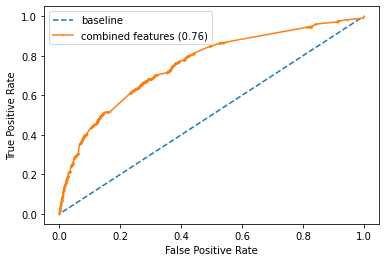

In [70]:
# Variant count only:
fpr_varcnt, tpr_varcnt, thresholds = roc_curve(weighted.positive_control, weighted.combined_features)
auc_varcnt = roc_auc_score(weighted.positive_control, weighted.combined_features)


# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_varcnt, tpr_varcnt, marker='.', markersize = 1, label=f'combined features ({auc_varcnt:.2})') # variant count


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

In [26]:
weight_series.sort_values()

feaure_332    0.000014
feaure_131    0.000065
feaure_333    0.000070
feaure_232    0.000194
feaure_132    0.000326
feaure_233    0.000331
feaure_322    0.000439
feaure_231    0.000751
feaure_121    0.001903
feaure_222    0.002627
feaure_211    0.002810
feaure_311    0.003841
feaure_123    0.004006
feaure_323    0.005004
feaure_213    0.005568
feaure_111    0.006132
feaure_113    0.007032
feaure_312    0.007762
feaure_122    0.008934
feaure_221    0.009564
feaure_313    0.011097
feaure_331    0.011424
feaure_112    0.014161
feaure_223    0.016238
feaure_133    0.025710
feaure_321    0.030960
feaure_212    0.823038
dtype: float64

In [72]:
# eva['combined_feature'] = eva.apply(lambda x: f"{eva_consequences_order_map[x['consequence']]}{review_status_order_map[x['review_status']]}{x['clinical_signif']}", axis=1)
# Order: consequence, review status, clinical significance
pd.concat([weight_series,eva.combined_feature.value_counts()], axis=1).sort_values(by=['combined_feature'])

# weight_series.index = weight_series.index.str.replace('feaure_','')



,0,combined_feature
13,NaN,2375.0
12,NaN,5195.0
31,NaN,13041.0
32,NaN,22698.0
22,NaN,31772.0
23,NaN,35619.0
33,NaN,70919.0
11,NaN,242702.0
21,NaN,382877.0
feature_11,0.124024,NaN


In [34]:
weight_series.index.str.replace('feaure_','')

Index(['111', '112', '113', '121', '122', '123', '131', '132', '133', '211',
       '212', '213', '221', '222', '223', '231', '232', '233', '311', '312',
       '313', '321', '322', '323', '331', '332', '333'],
      dtype='object')

In [37]:
weight_series

111    0.006132
112    0.014161
113    0.007032
121    0.001903
122    0.008934
123    0.004006
131    0.000065
132    0.000326
133    0.025710
211    0.002810
212    0.823038
213    0.005568
221    0.009564
222    0.002627
223    0.016238
231    0.000751
232    0.000194
233    0.000331
311    0.003841
312    0.007762
313    0.011097
321    0.030960
322    0.000439
323    0.005004
331    0.011424
332    0.000014
333    0.000070
dtype: float64

In [73]:
eva.head()

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,...,symbol,consequence,efo_id,label,literature,pharmaproject,pharmaproject_approved,poscon,clinical_signif,combined_feature
0,genetic_association,ENSG00000154803,Orphanet_2903,rs886037610,RCV000003542,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001589,...,FLCN,frameshift_variant,Orphanet_2903,Familial spontaneous pneumothorax,False,False,False,False,3,33
1,genetic_association,ENSG00000103197,Orphanet_805,rs137854012,RCV000042664,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,TSC2,frameshift_variant,Orphanet_805,Tuberous sclerosis,False,False,False,False,1,31
2,genetic_association,ENSG00000103197,Orphanet_805,rs137854007,RCV000042927,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,TSC2,frameshift_variant,Orphanet_805,Tuberous sclerosis,False,False,False,False,1,31
3,genetic_association,ENSG00000103197,Orphanet_805,rs397515245,RCV000055557,1.000000e-07,0,no assertion provided,[not provided],SO_0001822,...,TSC2,inframe_deletion,Orphanet_805,Tuberous sclerosis,False,False,False,False,1,21
4,genetic_association,ENSG00000129422,EFO_0002950,rs1554507029,RCV000161533,1.000000e-07,0,no assertion provided,[not provided],SO_0001574,...,MTUS1,splice_acceptor_variant,EFO_0002950,pregnancy,False,False,False,False,1,31


# Crude weight

In [80]:
eva = eva.assign(consequence_weighted = eva.consequence.map(eva_consequences_order_map),
           review_status_weighted = eva.review_status.map(review_status_order_map))
    
eva.head()

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,...,efo_id,label,literature,pharmaproject,pharmaproject_approved,poscon,clinical_signif,combined_feature,consequence_weighted,review_status_weighted
0,genetic_association,ENSG00000154803,Orphanet_2903,rs886037610,RCV000003542,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001589,...,Orphanet_2903,Familial spontaneous pneumothorax,False,False,False,False,3,33,3,1
1,genetic_association,ENSG00000103197,Orphanet_805,rs137854012,RCV000042664,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,Orphanet_805,Tuberous sclerosis,False,False,False,False,1,31,3,1
2,genetic_association,ENSG00000103197,Orphanet_805,rs137854007,RCV000042927,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,Orphanet_805,Tuberous sclerosis,False,False,False,False,1,31,3,1
3,genetic_association,ENSG00000103197,Orphanet_805,rs397515245,RCV000055557,1.000000e-07,0,no assertion provided,[not provided],SO_0001822,...,Orphanet_805,Tuberous sclerosis,False,False,False,False,1,21,2,1
4,genetic_association,ENSG00000129422,EFO_0002950,rs1554507029,RCV000161533,1.000000e-07,0,no assertion provided,[not provided],SO_0001574,...,EFO_0002950,pregnancy,False,False,False,False,1,31,3,1


Extract weights...
consequence_weighted      0.210848
clinical_signif           0.373705
review_status_weighted    0.415448
dtype: float64
Extract weights...
consequence_weighted    0.409889
clinical_signif         0.590111
dtype: float64
Extract weights...
clinical_signif           0.444735
review_status_weighted    0.555265
dtype: float64
Extract weights...
clinical_signif    1.0
dtype: float64
Extract weights...
consequence_weighted    1.0
dtype: float64


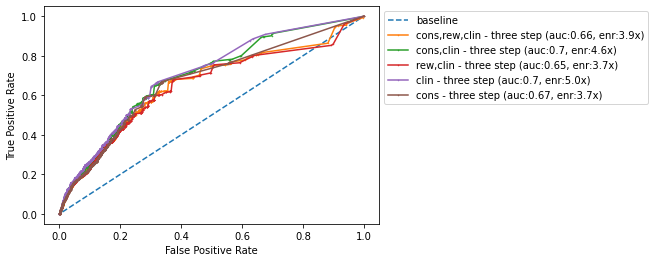

In [201]:
# This variable will contain all data:
results = {}

# These are the crude parameters:
columns = ['consequence_weighted','review_status_weighted','clinical_signif']
results['cons,rew,clin - three step'] = get_fit_parameters(eva,columns)

# These are the crude parameters:
columns = ['consequence_weighted','clinical_signif']
results['cons,clin - three step'] = get_fit_parameters(eva,columns)

# These are the crude parameters:
columns = ['review_status_weighted','clinical_signif']
results['rew,clin - three step'] = get_fit_parameters(eva,columns)

# These are the crude parameters:
columns = ['clinical_signif']
results['clin - three step'] = get_fit_parameters(eva,columns)

# These are the crude parameters:
columns = ['consequence_weighted']
results['cons - three step'] = get_fit_parameters(eva,columns)


plot_auc_all(results)

In [204]:
eva_consequences_order_map = {
    'downstream_gene_variant': 0.6,
    'upstream_gene_variant': 0.6,
    'intron_variant': 0.65,
    'non_coding_transcript_exon_variant': 0.65,
    '3_prime_UTR_variant': 0.65,
    '5_prime_UTR_variant': 0.65,
    'mature_miRNA_variant': 0.65,
    'coding_sequence_variant': 0.95,
    'synonymous_variant': 0.65,
    'stop_retained_variant': 0.65,
    'incomplete_terminal_codon_variant': 0.9,
    'splice_region_variant': 0.9,
    'protein_altering_variant': 0.7,
    'missense_variant': 0.7,
    'inframe_deletion': 0.7,
    'inframe_insertion': 0.7,
    'start_lost': 0.95,
    'stop_lost': 0.9,
    'frameshift_variant': 0.95,
    'stop_gained': 0.95,
    'splice_donor_variant': 0.95,
    'splice_acceptor_variant': 0.95,
    'trinucleotide_repeat_expansion': 1,
    'short_tandem_repeat_expansion': 1,
    'transcript_ablation':1
}

# Review status is an ordinal variable. Mapping to numbers:
review_status_order_map = {
    'no assertion provided': 1/7,
    'no assertion criteria provided': 2/7,
    'criteria provided, conflicting interpretations': 3/7,
    'criteria provided, single submitter': 4/7,
    'criteria provided, multiple submitters, no conflicts': 5/7,
    'reviewed by expert panel': 6/7,
    'practice guideline': 7/7
}

clinical_significance_mapping = {
    'association not found': 0,  
    'benign': 0,
    'not provided': 0,
    'uncertain significance': 0.01,    
    'likely benign': 0.2,    
    'conflicting interpretations of pathogenicity': 0.5,   
    'other': 0.3,
    'association': 1,
    'drug response': 1,
    'protective':1,
    'affects': 0.7,
    'likely pathogenic' : 0.8,
    'risk factor': 0.8,
    'pathogenic' : 1,
}

# These are the crude parameters:
columns = ['consequence_weighted','review_status_weighted','clinical_signif']

eva = eva.assign(consequence_weighted = eva.consequence.map(eva_consequences_order_map),
                review_status_weighted = eva.review_status.map(review_status_order_map),
                clinical_signif = eva.clinical_significance.apply(lambda x: max([clinical_significance_mapping[y] for y in x])))

eva.head()

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,...,efo_id,label,literature,pharmaproject,pharmaproject_approved,poscon,clinical_signif,combined_feature,consequence_weighted,review_status_weighted
0,genetic_association,ENSG00000154803,Orphanet_2903,rs886037610,RCV000003542,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001589,...,Orphanet_2903,Familial spontaneous pneumothorax,False,False,False,False,1.0,33,0.95,0.285714
1,genetic_association,ENSG00000103197,Orphanet_805,rs137854012,RCV000042664,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,Orphanet_805,Tuberous sclerosis,False,False,False,False,0.0,31,0.95,0.142857
2,genetic_association,ENSG00000103197,Orphanet_805,rs137854007,RCV000042927,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,Orphanet_805,Tuberous sclerosis,False,False,False,False,0.0,31,0.95,0.142857
3,genetic_association,ENSG00000103197,Orphanet_805,rs397515245,RCV000055557,1.000000e-07,0,no assertion provided,[not provided],SO_0001822,...,Orphanet_805,Tuberous sclerosis,False,False,False,False,0.0,21,0.70,0.142857
4,genetic_association,ENSG00000129422,EFO_0002950,rs1554507029,RCV000161533,1.000000e-07,0,no assertion provided,[not provided],SO_0001574,...,EFO_0002950,pregnancy,False,False,False,False,0.0,31,0.95,0.142857


Extract weights...
consequence_weighted      0.208942
review_status_weighted    0.392619
clinical_signif           0.398439
dtype: float64
Extract weights...
consequence_weighted    0.386698
clinical_signif         0.613302
dtype: float64
Extract weights...
clinical_signif           0.486927
review_status_weighted    0.513073
dtype: float64
Extract weights...
clinical_signif    1.0
dtype: float64
Extract weights...
consequence_weighted    1.0
dtype: float64


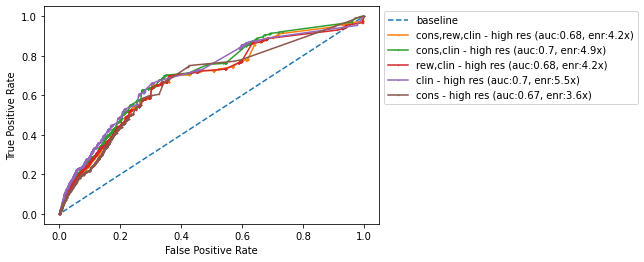

In [209]:
# This variable will contain all data:
results = {}

# These are the crude parameters:
columns = ['consequence_weighted','review_status_weighted','clinical_signif']
results['cons,rew,clin - high res'] = get_fit_parameters(eva,columns)

# These are the crude parameters:
columns = ['consequence_weighted','clinical_signif']
results['cons,clin - high res'] = get_fit_parameters(eva,columns)

# These are the crude parameters:
columns = ['review_status_weighted','clinical_signif']
results['rew,clin - high res'] = get_fit_parameters(eva,columns)

# These are the crude parameters:
columns = ['clinical_signif']
results['clin - high res'] = get_fit_parameters(eva,columns)

# These are the crude parameters:
columns = ['consequence_weighted']
results['cons - high res'] = get_fit_parameters(eva,columns)


plot_auc_all(results)

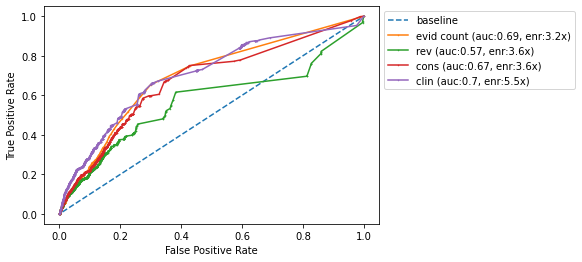

In [224]:
# This variable will contain all data:
results = {}

# baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)

# baseline:
columns = ['review_status_weighted']
results['rev'] = get_fit_parameters(eva.assign(baseline=1),columns)


# baseline:
columns = ['consequence_weighted']
results['cons'] = get_fit_parameters(eva.assign(baseline=1),columns)


# baseline:
columns = ['clinical_signif']
results['clin'] = get_fit_parameters(eva.assign(baseline=1),columns)


plot_auc_all(results)

In [217]:
eva = eva.assign(baseline=1)



## clinical significance

1. fine-tune weights
2. Split into three or four tiers.
3. Re-run 

In [234]:
# Get unique clinical significance values:
clin_sig_split = eva[['target','disease','poscon','clinical_significance']].copy()
clin_sig_split['clinical_signif'] = clin_sig_split.clinical_significance.apply(lambda x: x[0] if len(x) == 1 else None)

# Generate dummy features from clinical significance values:
clin_sig_split = pd.get_dummies(clin_sig_split, prefix='clin_sig', columns=['clinical_signif'])

# Update dummy columns were more then one clinical significance value is available:
for i, row in clin_sig_split.loc[clin_sig_split.clinical_significance.apply(lambda x: True if len(x)>1 else False)].iterrows():
    for sig_val in row['clinical_significance']:
        clin_sig_split.loc[i,f'clin_sig_{sig_val}'] = 1
        

Extract weights...
clin_sig_association not found                           0.000107
clin_sig_association                                     0.001254
clin_sig_drug response                                   0.003246
clin_sig_protective                                      0.003372
clin_sig_affects                                         0.005201
clin_sig_conflicting interpretations of pathogenicity    0.007977
clin_sig_risk factor                                     0.014480
clin_sig_not provided                                    0.023414
clin_sig_likely benign                                   0.038207
clin_sig_other                                           0.060810
clin_sig_pathogenic                                      0.061685
clin_sig_uncertain significance                          0.086585
clin_sig_benign                                          0.098472
clin_sig_likely pathogenic                               0.595189
dtype: float64


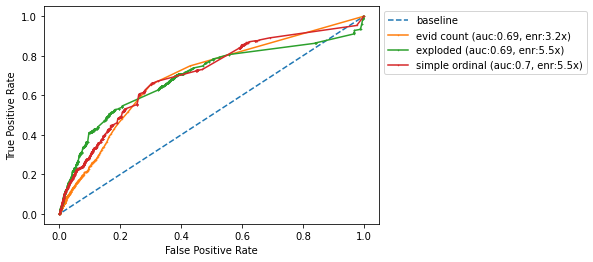

In [235]:
# baseline:
results ={}
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)

# baseline:
columns = [x for x in clin_sig_split.columns if 'clin_sig' in x]
results['exploded'] = get_fit_parameters(clin_sig_split, columns)

# baseline:
columns = ['clinical_signif']
results['simple ordinal'] = get_fit_parameters(eva.assign(baseline=1),columns)


plot_auc_all(results)

# Clinical significance - tweeked weights

```
clin_sig_association not found                           0.000107
clin_sig_association                                     0.001254
clin_sig_drug response                                   0.003246
clin_sig_protective                                      0.003372
clin_sig_affects                                         0.005201
clin_sig_conflicting interpretations of pathogenicity    0.007977
clin_sig_risk factor                                     0.014480
clin_sig_not provided                                    0.023414
clin_sig_likely benign                                   0.038207
clin_sig_other                                           0.060810
clin_sig_pathogenic                                      0.061685
clin_sig_uncertain significance                          0.086585
clin_sig_benign                                          0.098472
clin_sig_likely pathogenic                               0.595189
```

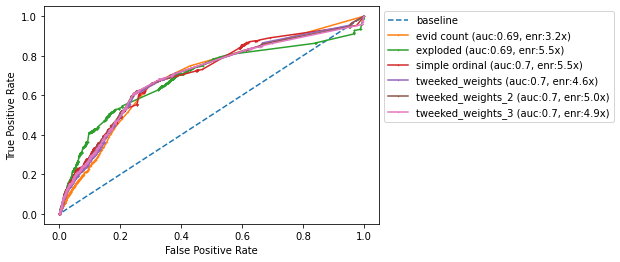

In [253]:
clinical_significance_mapping = {
    # Less severe:
    'association not found': 0.5,  
    'benign': 0.5,
    'not provided': 0.5,    
    'likely benign': 4,    
    
    # More severe:
    'conflicting interpretations of pathogenicity': 2,   
    'other': 2,
    'uncertain significance': 2,
    'risk factor': 2,
    'affects': 2,
    
    # Most severe:
    'likely pathogenic' : 6,
    'association': 6,
    'drug response': 6,
    'protective': 6,
    'pathogenic': 6,
}


weights = pd.Series([0.000107, 0.001254, 0.003246, 0.003372, 0.005201, 0.007977, 0.014480, 0.023414, 0.038207, 0.060810, 0.061685, 0.086585, 0.098472, 0.595189],\
          index=["clin_sig_association not found", "clin_sig_association", "clin_sig_drug response", "clin_sig_protective", "clin_sig_affects", "clin_sig_conflicting interpretations of pathogenicity", "clin_sig_risk factor", "clin_sig_not provided", "clin_sig_likely benign", "clin_sig_other", "clin_sig_pathogenic", "clin_sig_uncertain significance", "clin_sig_benign", "clin_sig_likely pathogenic"])

# baseline:
columns = ['tweeked_weights']
results['tweeked_weights_3'] = get_fit_parameters(eva.loc[eva.clinical_significance.apply(lambda x: True if 'benign' not in x else False)].assign(tweeked_weights=eva.clinical_significance.apply(lambda x: max([clinical_significance_mapping[y] for y in x]))),columns)


plot_auc_all(results)

In [255]:
eva.loc[eva.clinical_significance.apply(lambda x: True if 'benign' not in x else False) & (eva.poscon)]




,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,...,label,literature,pharmaproject,pharmaproject_approved,poscon,clinical_signif,combined_feature,consequence_weighted,review_status_weighted,baseline
123,genetic_association,ENSG00000181027,MONDO_0011688,rs104894679,RCV000004439,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001583,...,muscular dystrophy-dystroglycanopathy type B5,True,False,False,True,1.00,23,0.70,0.285714,1
199,genetic_association,ENSG00000130707,Orphanet_247525,rs121908648,RCV000006711,1.000000e-07,1,"criteria provided, single submitter",[uncertain significance],SO_0001583,...,Citrullinemia type I,True,False,False,True,0.01,21,0.70,0.571429,1
552,genetic_association,ENSG00000198947,Orphanet_98895,rs1557211730,RCV000012041,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001627,...,Becker muscular dystrophy,True,False,False,True,1.00,13,0.65,0.285714,1
659,genetic_association,ENSG00000186868,Orphanet_683,rs63750425,RCV000015337,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001583,...,Progressive supranuclear palsy,True,False,False,True,1.00,23,0.70,0.285714,1
661,genetic_association,ENSG00000186868,Orphanet_683,rs63751391,RCV000015339,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001583,...,Progressive supranuclear palsy,True,False,False,True,1.00,23,0.70,0.285714,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807124,genetic_association,ENSG00000166311,EFO_1001380,rs727504166,RCV001248935,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001583,...,Niemann-Pick disease,False,True,False,True,1.00,23,0.70,0.285714,1
807126,genetic_association,ENSG00000166311,EFO_1001380,rs120074117,RCV001248980,1.000000e-07,0,no assertion criteria provided,[likely pathogenic],SO_0001583,...,Niemann-Pick disease,False,True,False,True,0.80,22,0.70,0.285714,1
807128,genetic_association,ENSG00000177628,Orphanet_355,rs398123530,RCV001249029,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001583,...,Gaucher disease,True,False,False,True,1.00,23,0.70,0.285714,1
807129,genetic_association,ENSG00000166311,EFO_1001380,rs753508874,RCV001249039,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001583,...,Niemann-Pick disease,False,True,False,True,1.00,23,0.70,0.285714,1


In [239]:
%load_ext rpy2.ipython



/Users/dsuveges/opt/anaconda3/envs/jupyter/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [271]:

prefix = 'rev'
colnames = ['review_status','consequence']

def hot1(db, columns, prefix):

    # Get unique clinical significance values:
    feature_df = df[['target','disease','poscon'] + columns].copy()

    # Generate dummy features from clinical significance values:
    feature_df = pd.get_dummies(feature_df, prefix=prefix, columns=columns)

    cols = [x for x in feature_df.columns if f'{prefix}_' in x]
    return  get_fit_parameters(feature_df, cols)




Extract weights...
rev_incomplete_terminal_codon_variant                       0.000190
rev_short_tandem_repeat_expansion                           0.000258
rev_mature_miRNA_variant                                    0.000284
rev_non_coding_transcript_exon_variant                      0.000300
rev_stop_retained_variant                                   0.000305
rev_coding_sequence_variant                                 0.000310
rev_transcript_ablation                                     0.000392
rev_practice guideline                                      0.000777
rev_protein_altering_variant                                0.001222
rev_stop_lost                                               0.001489
rev_start_lost                                              0.004005
rev_splice_acceptor_variant                                 0.004313
rev_inframe_deletion                                        0.005243
rev_inframe_insertion                                       0.005305
rev_trinucleoti

{'fpr': array([0.00000000e+00, 3.40101350e-05, 1.02030405e-04, ...,
        9.99897970e-01, 9.99965990e-01, 1.00000000e+00]),
 'tpr': array([0., 0., 0., ..., 1., 1., 1.]),
 'auc': 0.751456253532673,
 'recovery': 60,
 'enrichment': 5.794055742323102}

In [265]:
colnames

['review_status']

In [266]:
feature_df

,target,disease,poscon,review_status
0,ENSG00000154803,Orphanet_2903,False,no assertion criteria provided
1,ENSG00000103197,Orphanet_805,False,no assertion provided
2,ENSG00000103197,Orphanet_805,False,no assertion provided
3,ENSG00000103197,Orphanet_805,False,no assertion provided
4,ENSG00000129422,EFO_0002950,False,no assertion provided
...,...,...,...,...
807193,ENSG00000244474,Orphanet_79234,False,"criteria provided, single submitter"
807194,ENSG00000171487,Orphanet_400008,False,no assertion criteria provided
807195,ENSG00000101104,Orphanet_404466,False,no assertion criteria provided
807196,ENSG00000105877,Orphanet_244,False,no assertion criteria provided


Extract weights...
rev_practice guideline                                      0.002318
rev_criteria provided, conflicting interpretations          0.016248
rev_no assertion provided                                   0.017750
rev_criteria provided, multiple submitters, no conflicts    0.055279
rev_criteria provided, single submitter                     0.144750
rev_reviewed by expert panel                                0.206210
rev_no assertion criteria provided                          0.557444
dtype: float64


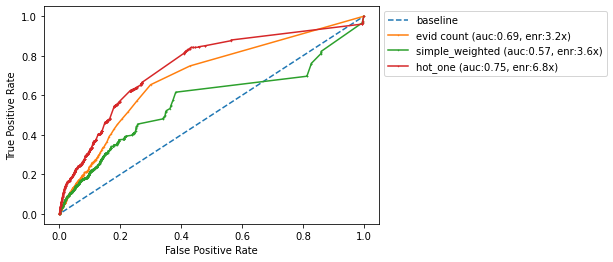

In [277]:
# hot1(db, columns, prefix)
results = {}

# baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)

# review status - simple weighted:
results['simple_weighted'] = get_fit_parameters(eva, ['review_status_weighted'])
       
# review status - hot one weighted:
results['hot_one'] = hot1(eva, ['review_status'], 'rev')

plot_auc_all(results)

Extract weights...
cons_incomplete_terminal_codon_variant     0.000638
cons_short_tandem_repeat_expansion         0.000662
cons_stop_retained_variant                 0.000713
cons_mature_miRNA_variant                  0.000822
cons_coding_sequence_variant               0.000897
cons_non_coding_transcript_exon_variant    0.001074
cons_transcript_ablation                   0.001116
cons_stop_lost                             0.002626
cons_splice_acceptor_variant               0.003126
cons_protein_altering_variant              0.003135
cons_inframe_deletion                      0.005346
cons_splice_donor_variant                  0.006502
cons_start_lost                            0.006576
cons_stop_gained                           0.007027
cons_splice_region_variant                 0.007446
cons_downstream_gene_variant               0.009397
cons_frameshift_variant                    0.010665
cons_inframe_insertion                     0.016637
cons_synonymous_variant                    0.

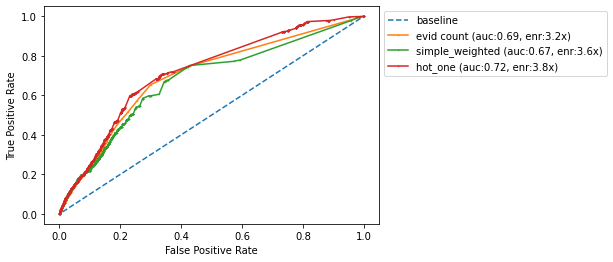

In [279]:
# hot1(db, columns, prefix)
results = {}

# baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)

# review status - simple weighted:
results['simple_weighted'] = get_fit_parameters(eva, ['consequence_weighted'])
       
# review status - hot one weighted:
results['hot_one'] = hot1(eva, ['consequence'], 'cons')

plot_auc_all(results)

Extract weights...
clin_association not found                           0.000150
clin_association                                     0.000670
clin_protective                                      0.002696
clin_drug response                                   0.004355
clin_conflicting interpretations of pathogenicity    0.004734
clin_affects                                         0.005934
clin_risk factor                                     0.009704
clin_not provided                                    0.030930
clin_likely benign                                   0.035898
clin_pathogenic                                      0.048442
clin_other                                           0.072276
clin_uncertain significance                          0.107822
clin_benign                                          0.129608
clin_likely pathogenic                               0.546781
dtype: float64


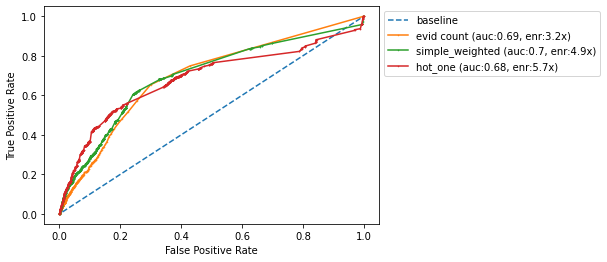

In [288]:
# hot1(db, columns, prefix)
results = {}

# baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)

# clinical siginificance - simple weighted:
results['simple_weighted'] = get_fit_parameters(eva.loc[eva.clinical_significance.apply(lambda x: True if 'benign' not in x else False)].assign(tweeked_weights=eva.clinical_significance.apply(lambda x: max([clinical_significance_mapping[y] for y in x]))), ['tweeked_weights'])
       
# clinical siginificance - hot one weighted:
results['hot_one'] = hot1(eva, ['simplified_clinical_signif'], 'clin')

plot_auc_all(results)

In [280]:
eva.columns

Index(['type', 'target', 'disease', 'rsid', 'clinvar_acces', 'score', 'star',
       'review_status', 'clinical_significance', 'so_code', 'gene_id',
       'symbol', 'consequence', 'efo_id', 'label', 'literature',
       'pharmaproject', 'pharmaproject_approved', 'poscon', 'clinical_signif',
       'combined_feature', 'consequence_weighted', 'review_status_weighted',
       'baseline'],
      dtype='object')

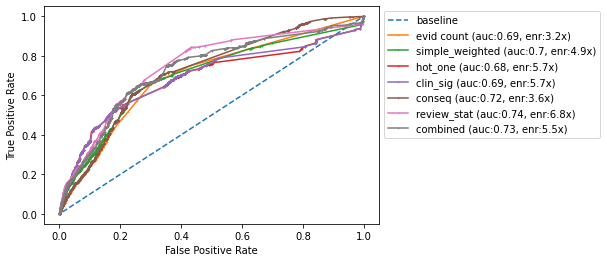

In [291]:
results = {}

columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)

# clinical siginificance - hot one weighted:
results['clin_sig'] = hot1(eva, ['simplified_clinical_signif'], 'clin')

# clinical siginificance - hot one weighted:
results['conseq'] = hot1(eva, ['consequence'], 'clin')

# clinical siginificance - hot one weighted:
results['review_stat'] = hot1(eva, ['review_status'], 'clin')

# clinical siginificance - hot one weighted:
results['combined'] = hot1(eva, ['simplified_clinical_signif','review_status','consequence'], 'clin')
plot_auc_all(results)

In [287]:
eva['simplified_clinical_signif'] = eva.clinical_significance.apply(lambda x: x[0] if len(x)==1 else None)
eva.head()

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,...,literature,pharmaproject,pharmaproject_approved,poscon,clinical_signif,combined_feature,consequence_weighted,review_status_weighted,baseline,simplified_clinical_signif
0,genetic_association,ENSG00000154803,Orphanet_2903,rs886037610,RCV000003542,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001589,...,False,False,False,False,1.0,33,0.95,0.285714,1,pathogenic
1,genetic_association,ENSG00000103197,Orphanet_805,rs137854012,RCV000042664,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,False,False,False,False,0.0,31,0.95,0.142857,1,not provided
2,genetic_association,ENSG00000103197,Orphanet_805,rs137854007,RCV000042927,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,False,False,False,False,0.0,31,0.95,0.142857,1,not provided
3,genetic_association,ENSG00000103197,Orphanet_805,rs397515245,RCV000055557,1.000000e-07,0,no assertion provided,[not provided],SO_0001822,...,False,False,False,False,0.0,21,0.70,0.142857,1,not provided
4,genetic_association,ENSG00000129422,EFO_0002950,rs1554507029,RCV000161533,1.000000e-07,0,no assertion provided,[not provided],SO_0001574,...,False,False,False,False,0.0,31,0.95,0.142857,1,not provided
